Import Libraries

In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

dataroot = '../WaterLevelPrediction_SelectingModel//Data/'

Load the data

In [32]:
df = pd.read_pickle(dataroot+'finaldata.pkl')

Time Series Cross Validation

In [33]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=6, test_size=365)
df = df.sort_index()

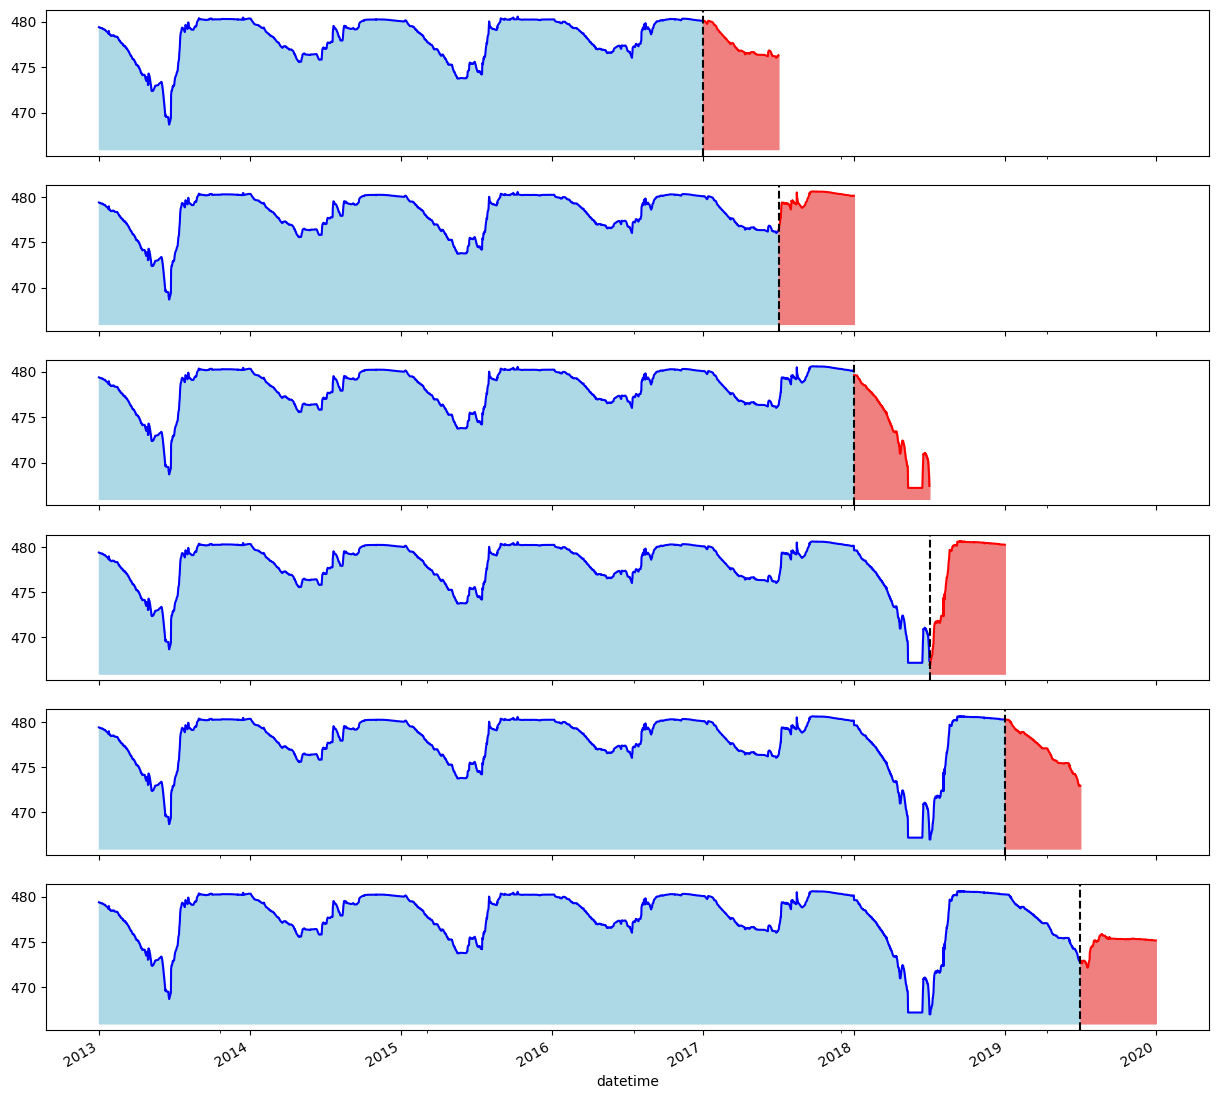

In [34]:
fig, axs = plt.subplots(6,1, figsize = (15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['water_level'].plot(ax=axs[fold],
                              label='Tập huấn luyện',
                              color='blue')
    test['water_level'].plot(ax=axs[fold],
                             label='Tập kiểm thử',
                             color='red')
    axs[fold].fill_between(train.index,466, train['water_level'], color='lightblue')
    axs[fold].fill_between(test.index,466, test['water_level'], color='lightcoral')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1
plt.show()

Train the model with first features set

In [35]:
from sklearn.linear_model import LinearRegression

fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    
    y_pred = lin_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

Model Parameter

In [36]:
print (lin_reg.coef_)
print (lin_reg.intercept_)

[-0.0225205   0.08076672]
477.74760023054694


Model Evaluation

In [37]:
print(f'root mean squared error across folds:{np.mean(rmses)}')
print(f'scores for each folds:{rmses}')

root mean squared error across folds:3.144900435228381
scores for each folds:[1.6277494066001854, 1.9090571415216933, 6.346486398015272, 3.9545392089664397, 2.1163764408410555, 2.915194015425642]


In [38]:
print(f'root mean squared error across folds:{np.mean(maes)}')
print(f'scores for each folds:{maes}')

root mean squared error across folds:2.704969659556777
scores for each folds:[1.4957868018463185, 1.8032326823342542, 5.000176534745552, 3.4219678814945125, 1.7319911898631646, 2.7766628670568574]


In [39]:
print(f'r2 score across on train set:{np.mean(r2s)}')
print(f'scores for each folds:{r2s}')

r2 score across on train set:-2.730372274697404
scores for each folds:[-0.4484460803870207, -4.808786919057994, -1.2335111724411703, -0.019573673793787494, -0.1845740190636227, -9.687341783440832]


Lag Feature

In [40]:
def add_lag(df):
    target_map = df['water_level'].to_dict() # mapping water level
    df['lag'] = (df.index - pd.Timedelta('12 hours')).map(target_map)# lag 12 hours
    return df

df = add_lag(df)
df = df.dropna(subset=['lag'])# drop the NaN value because linear regression won't accept it

df.loc['2013-06-19':'2013-06-24']


,year,month,day,water_level,hour,precipitation,sluice_status,lag
datetime,,,,,,,,
2013-06-19 07:00:00,2013,6,19,469.05,7,0.0,2,469.05
2013-06-19 19:00:00,2013,6,19,468.70,19,0.0,2,469.05
2013-06-20 07:00:00,2013,6,20,468.70,7,0.0,0,468.70
2013-06-24 19:00:00,2013,6,24,472.00,19,79.0,0,469.40


Retrain the model with second feature set

In [56]:
from sklearn.linear_model import LinearRegression

fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    
    y_pred = lin_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

In [57]:
print(f'root mean squared error across folds:{np.mean(rmses)}')
print(f'scores for each folds:{rmses}')

root mean squared error across folds:0.094022904590429
scores for each folds:[0.03508457649003591, 0.07753309008029603, 0.1668414386644875, 0.19194242072554707, 0.040487465673760804, 0.052248435908446744]


In [58]:
print(f'root mean squared error across folds:{np.mean(maes)}')
print(f'scores for each folds:{maes}')

root mean squared error across folds:0.04085226946553197
scores for each folds:[0.02436903988276869, 0.03549774643140733, 0.07117766291319372, 0.061903390542841885, 0.026107344529493762, 0.026058432493486435]


In [59]:
print(f'r2 score across on train set:{np.mean(r2s)}')
print(f'scores for each folds:{r2s}')

r2 score across on train set:0.9969889498792113
scores for each folds:[0.9993270857605783, 0.9904187587325509, 0.9984564195330042, 0.9975980233749445, 0.999566471600936, 0.9965669402732533]


In [60]:
print (lin_reg.coef_)
print (lin_reg.intercept_)

[ 0.00644869 -0.00267391  1.00092908]
-0.4516785654461728


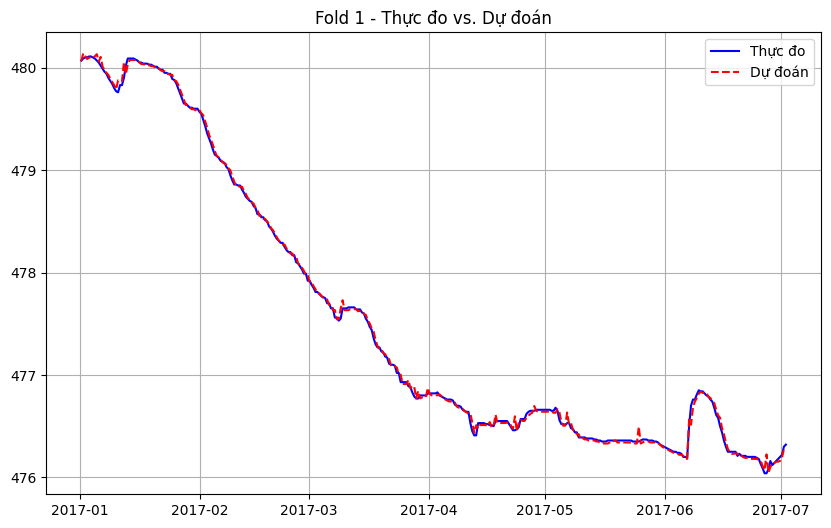

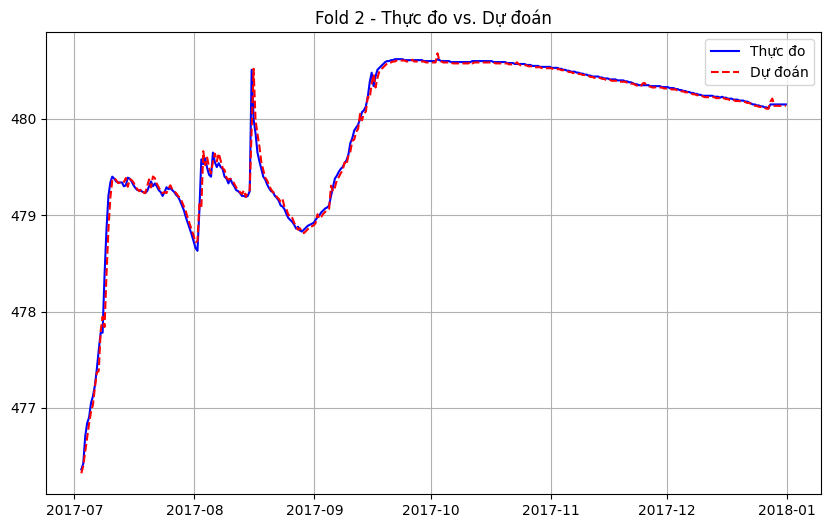

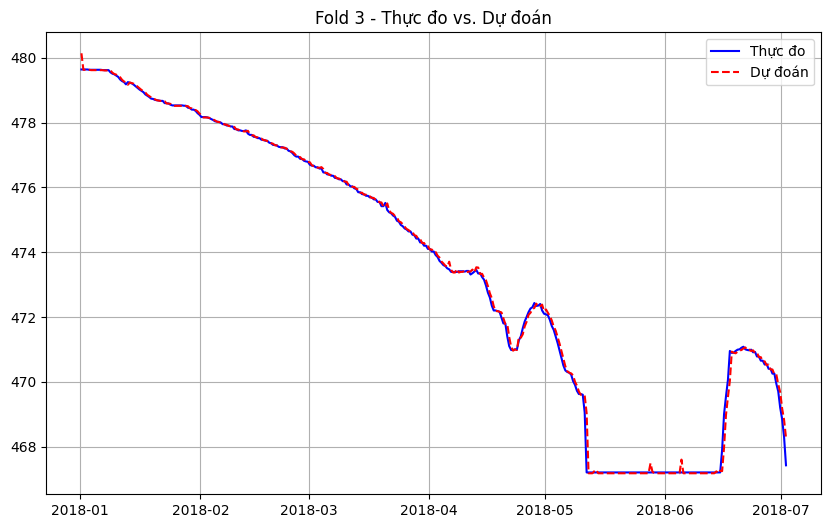

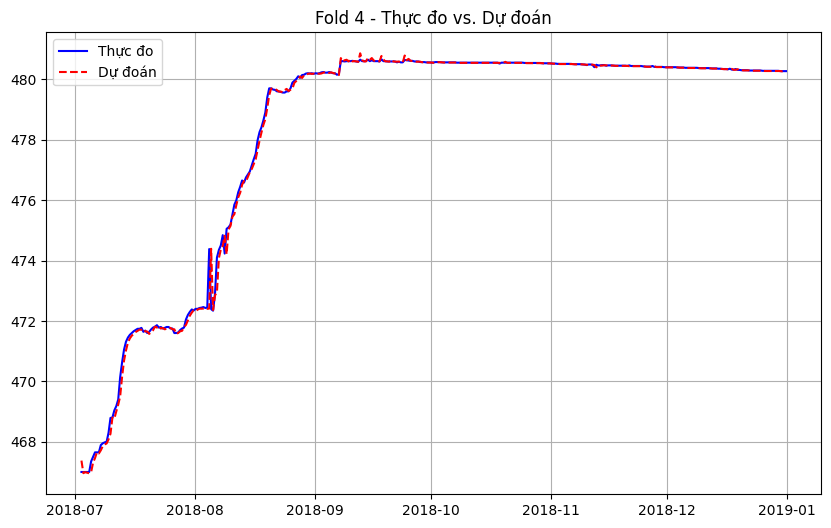

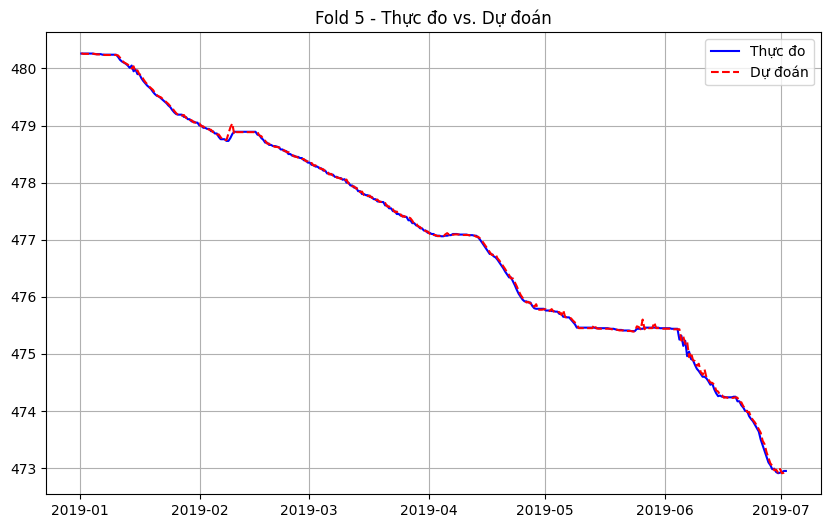

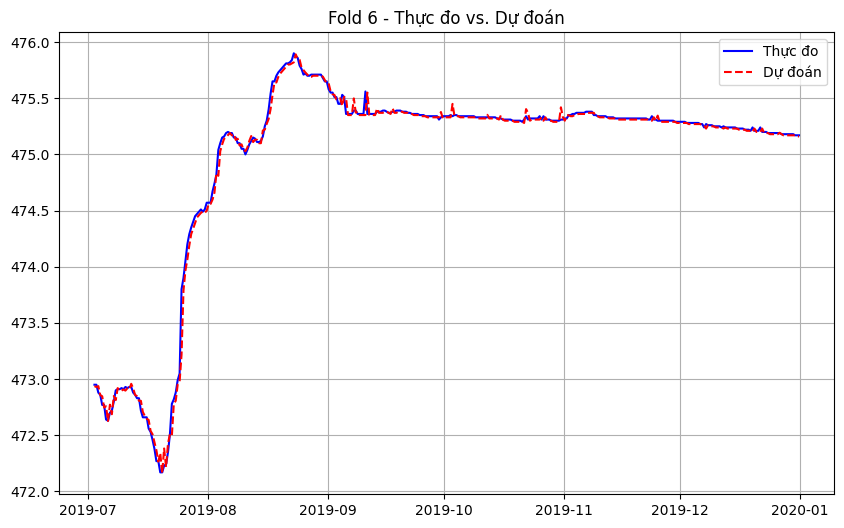

In [61]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['water_level'], label='Thực đo', color='blue')
    plt.plot(test.index, preds[fold], label='Dự đoán', color='red', linestyle='dashed')
    fold += 1

    plt.title('Fold {} - Thực đo vs. Dự đoán'.format(fold))

    plt.legend()
    plt.grid()
    plt.show()

Retrain the model with all data

In [47]:
X_all = df[features]
y_all = df[target]

lin_reg = LinearRegression()
lin_reg.fit(X_all, y_all)

LinearRegression()

Save the model for Deployment

In [48]:
import joblib
lin_reg_file = 'linear_regression.joblib'
joblib.dump(lin_reg, lin_reg_file)

['linear_regression.joblib']

In [49]:
# Load the trained model
lin_reg = joblib.load(lin_reg_file)

# Prepare the input data for prediction
input_data = {
    'precipitation': [27,49,26],
    'sluice_status': [0,0,0],
    'lag': [471.8,472.35,473.15]
}

# Create a dataframe from the input data
input_df = pd.DataFrame(input_data)

# Make predictions
predictions = lin_reg.predict(input_df)

# Round the predictions to 2 decimal places
predictions = [round(pred, 2) for pred in predictions]

# Print the predictions
print(predictions)


[471.96, 472.65, 473.31]
